In [1]:
import cudf
import numpy as np
import sys
import os
import argparse
import pickle
import fnmatch
from tqdm import tqdm
import re
import itertools
import random
import argparse
import matplotlib.pyplot as plt

ROOTDIR = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/'
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier = 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'

num_subsamples = 100
k = 100
hier_idx = 0
layers = ['layer_0_Input', 'layer_1_Linear', 'layer_2_Linear', 'layer_3_Linear']
layer = layers[1]

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-54i66we6 because the default path (/home/gretatu/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
pkl_name = f'layer={layer}_hier={hier_idx}.pkl'

SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)

In [4]:
SAVEDIR

'/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/analyze/knn_k=100_subsamples=100/NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed/epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'

In [5]:
data = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))


In [17]:
data.keys()
D = data['D']
I = data['I']
epochs = data['epochs']

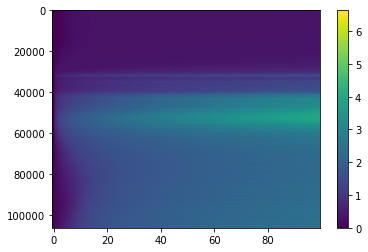

In [8]:
plt.imshow(data['D'],aspect='auto',interpolation=None)
plt.colorbar()

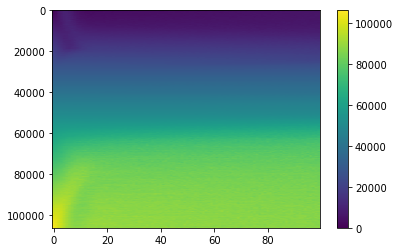

In [9]:
plt.imshow(data['I'],aspect='auto',interpolation=None)
plt.colorbar()

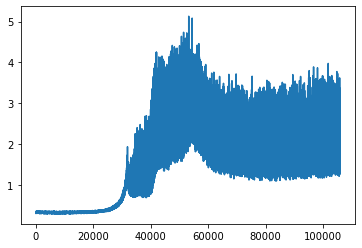

In [12]:
plt.plot(np.mean(data['D'],axis=1))

In [55]:
hier_idx=5
pkl_name = f'layer={layer}_hier={hier_idx}.pkl'
data1 = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))

In [56]:
p_array = [5, 50, 95]
p = np.percentile(data['I'], p_array, axis=1)
p1 = np.percentile(data1['I'], p_array, axis=1)

In [57]:
p.shape

(3, 106000)

In [85]:
time_diag = np.arange(p.shape[1])

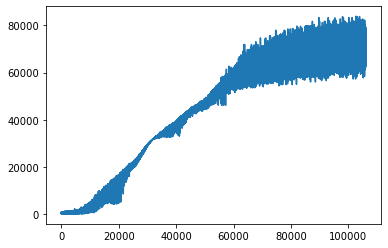

In [17]:
plt.plot(p[0,:])

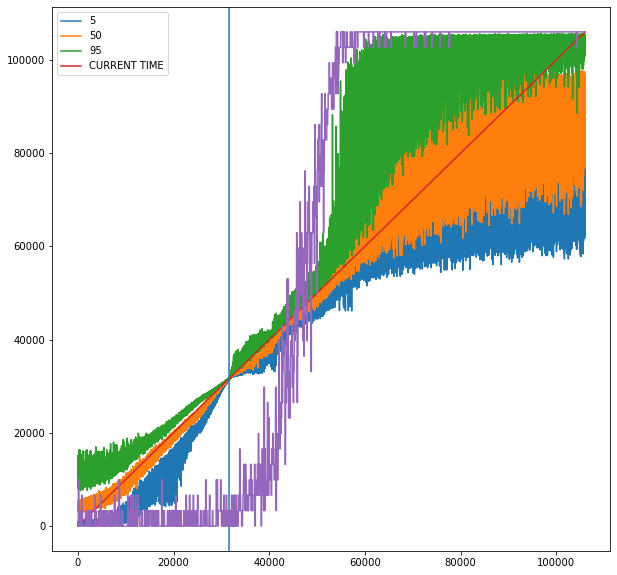

In [95]:
plt.figure(figsize=(10,10))
plt.plot(p[0,:], label=p_array[0])
plt.plot(p[1,:], label=p_array[1])
plt.plot(p[2,:], label=p_array[2])
plt.plot(time_diag, label='CURRENT TIME')
plt.axvline(x=31622)
plt.plot(np.ravel([np.repeat(x,100) for x in data['test_accs']])*1060)
plt.legend()

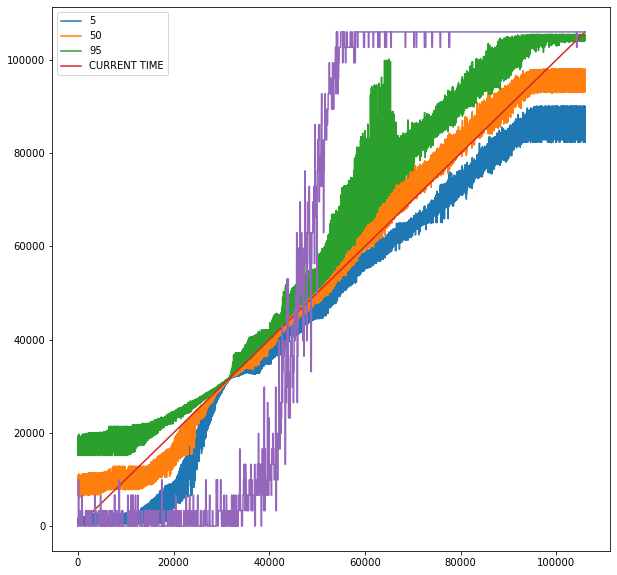

In [59]:
plt.figure(figsize=(10,10))
plt.plot(p1[0,:], label=p_array[0])
plt.plot(p1[1,:], label=p_array[1])
plt.plot(p1[2,:], label=p_array[2])
plt.plot(time_diag, label='CURRENT TIME')
plt.plot(np.ravel([np.repeat(x,100) for x in data['test_accs']])*1060)
plt.legend()

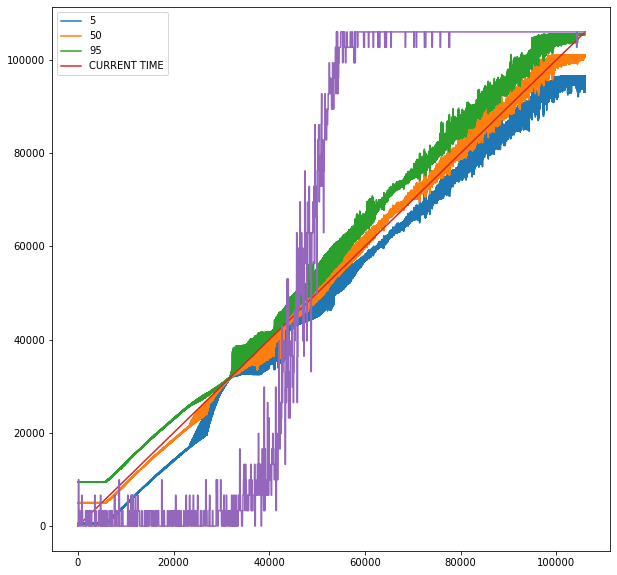

In [63]:
plt.figure(figsize=(10,10))
plt.plot(p1[0,:], label=p_array[0])
plt.plot(p1[1,:], label=p_array[1])
plt.plot(p1[2,:], label=p_array[2])
plt.plot(time_diag, label='CURRENT TIME')
plt.plot(np.ravel([np.repeat(x,100) for x in data['test_accs']])*1060)
plt.legend()

In [88]:
a = [(time_diag[x]) == (p[1,x]) for x in range(p.shape[1])]

In [89]:
for e in range(p.shape[1]):
    if time_diag[e] == p[1,e]:
        print('true')

In [91]:
diffs = abs(time_diag - p[1,:])

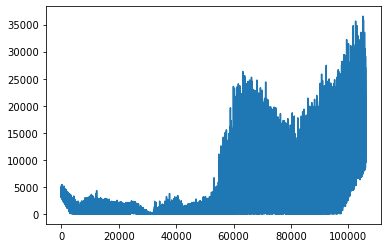

In [92]:
plt.plot(diffs)

In [93]:
np.argmin(diffs) # same as the method below with the "norms"

5895

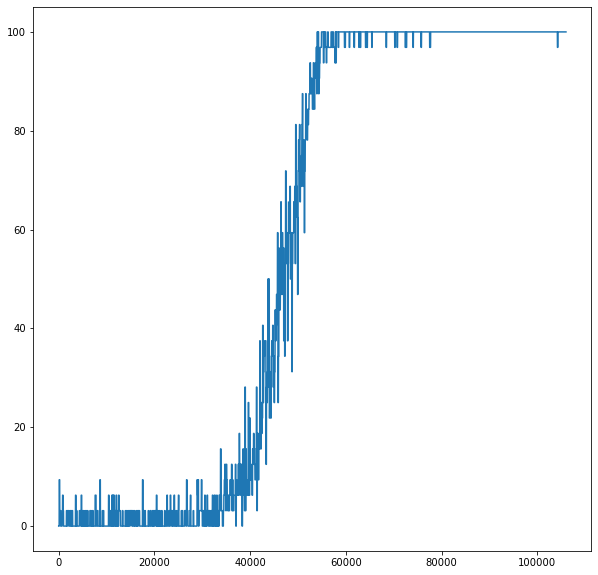

In [53]:
plt.figure(figsize=(10,10))
plt.plot(np.ravel([np.repeat(x,100) for x in data['test_accs']]))

In [40]:
time_diag = np.arange(p.shape[1])

In [ ]:
# we can also avg across subsamples to get a nicer picture

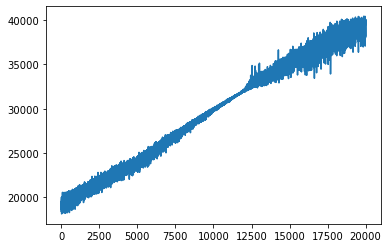

In [20]:
plt.plot(p[1,20000:40000])


In [27]:
# di = np.diag_indices(data['I'])

In [28]:
g = p[1,:]

In [29]:
g.shape

(106000,)

In [ ]:
## find fixed point ##

In [21]:
norms = np.zeros((k-1, 106000))
for i in range(1, k):
    norms[i-1, :] = I[:, 0] - I[:, i] # do abs

In [14]:
I[:, 0] - I[:, i]

array([-2771, -2069, -4495, ...,   282,   422,  1926])

In [19]:
len(epochs)

1060

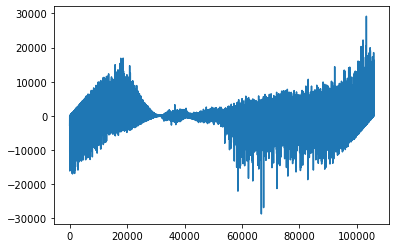

In [29]:
plt.plot(norms[0])

In [ ]:
# up (positive vals) means that the representation is looking BACKWARD in time!

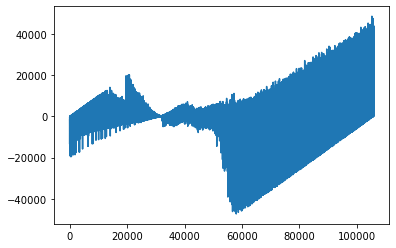

In [30]:
plt.plot(norms[97])

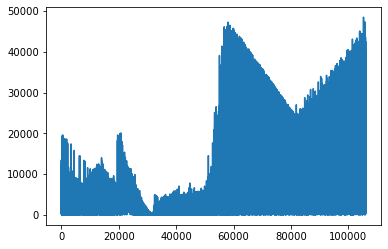

In [31]:
plt.plot(abs(norms[97]))

In [36]:
mean_k_norms = np.mean(norms,axis=1)

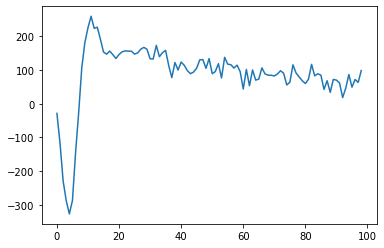

In [37]:
plt.plot(mean_k_norms)

In [38]:
# this means that the FIRST neighbors, for every point, are most similar to ones backward in time, while other neighbors
# are more forward-looking

In [39]:
mean_norms = np.mean(norms,axis=0)

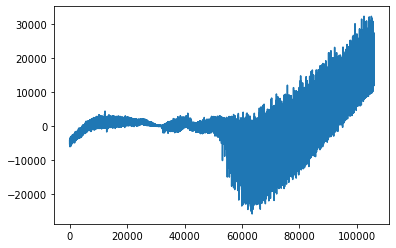

In [40]:
plt.plot(mean_norms)

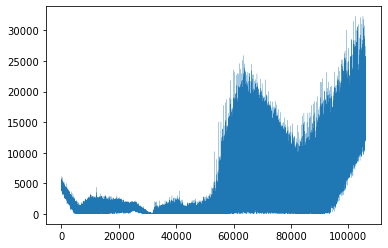

In [43]:
plt.plot(abs(mean_norms),linewidth=0.2)

In [48]:
np.argmin(abs(mean_norms))

8411

In [49]:
np.min(abs(mean_norms))

0.010101010101010102

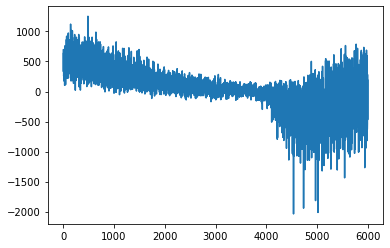

In [47]:
plt.plot(mean_norms[28000:34000])

In [50]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

av_window=10

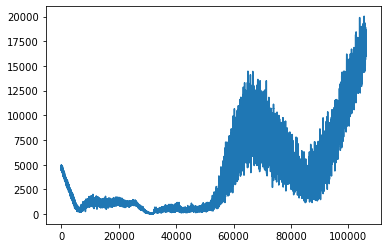

In [52]:
plt.plot(moving_average(abs(mean_norms),av_window))

In [53]:
np.argmin(moving_average(abs(mean_norms),av_window)) # fixed point!

31622

In [94]:
np.argmin(moving_average(diffs,av_window)) # check with method above, same

31622